<a href="https://colab.research.google.com/github/hyomin14/python_ML_practice/blob/main/04_Classification/Chapter4_ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **앙상블 학습**

여러 개의 분류기를 생성하고 그 예측을 결합하여 보다 정확한 최종 예측 도출

## **보팅 분류기(Voting Classifier)**

여러 개의 분류기가 투표를 통해 최종 예측 결과 결정, 서로 다른 알고리즘을 가진 분류기 결합
1.	하드 보팅:  예측한 결과값 중 다수의 분류기가 결정한 예측값을 최종 보팅 결과값으로 선정
2. 소프트 보팅: 분류기의 레이블 값 결정 확률을 모두 더하고 평균해서 확률이 가장 높은 레이블 값을 최종 보팅 결과값으로 선정


In [ ]:
import pandas as pd

from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer         #이진 분류 데이터 세트
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer = load_breast_cancer()

data_df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
data_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [ ]:
#개별 모델은 로지스틱 회귀와 KNN
lr_clf = LogisticRegression()
knn_clf = KNeighborsClassifier(n_neighbors=8)

#개별 모델을 소프트 보팅 기반의 앙상블 모델로 구현한 분류기
#VotingClassfier 주요 생성 인자 estimators: 리스트, 보팅에 사용된 여러 개의 Classifier 객체를 튜플 형식으로, voting: hard/soft
vo_clf = VotingClassifier( estimators=[('LR',lr_clf),('KNN',knn_clf)] , voting='soft' )

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, 
                                                    test_size=0.2 , random_state= 156)

# VotingClassifier 학습/예측/평가. 
vo_clf.fit(X_train , y_train)
pred = vo_clf.predict(X_test)
print('Voting 분류기 정확도: {0:.4f}'.format(accuracy_score(y_test , pred)))

# 개별 모델의 학습/예측/평가.
classifiers = [lr_clf, knn_clf]
for classifier in classifiers:
    classifier.fit(X_train , y_train)
    pred = classifier.predict(X_test)
    class_name= classifier.__class__.__name__
    print('{0} 정확도: {1:.4f}'.format(class_name, accuracy_score(y_test , pred)))

Voting 분류기 정확도: 0.9474
LogisticRegression 정확도: 0.9386
KNeighborsClassifier 정확도: 0.9386


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


## **랜덤 포레스트**

배깅(Bagging)의 대표적인 알고리즘

여러 개의 결정 트리 분류기가 전체 데이터에서 배깅 방식으로 각자의 데이터를 샘플링해 개별적으로 학습 수행 후 보팅을 통해 예측 결정

배깅: 같은 알고리즘으로 여러 개의 분류기 만들어서 보팅으로 최종 결정

In [ ]:
#중복된 피처명은 원본 피처명에 _1, _2를 추가로 부여해 새로운 피처명 가지는 DataFrame 반환하는 함수 생성
import pandas as pd

def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(),
                                  columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) 
                                                                                         if x[1] >0 else x[0] ,  axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

def get_human_dataset( ):
    
    # 각 데이터 파일들은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당.
    feature_name_df = pd.read_csv('features.txt',sep='\s+',header=None,names=['column_index','column_name'])
    
    # 중복된 피처명을 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 DataFrame생성. 
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    
    # DataFrame에 피처명을 컬럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    
    # 학습 피처 데이터 셋과 테스트 피처 데이터을 DataFrame으로 로딩. 컬럼명은 feature_name 적용
    X_train = pd.read_csv('X_train.txt',sep='\s+', names=feature_name )
    X_test = pd.read_csv('X_test.txt',sep='\s+', names=feature_name)
    
    # 학습 레이블과 테스트 레이블 데이터을 DataFrame으로 로딩하고 컬럼명은 action으로 부여
    y_train = pd.read_csv('y_train.txt',sep='\s+',header=None,names=['action'])
    y_test = pd.read_csv('y_test.txt',sep='\s+',header=None,names=['action'])
    
    # 로드된 학습/테스트용 DataFrame을 모두 반환 
    return X_train, X_test, y_train, y_test

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

#결정 트리에서 사용한 get_human_dataset()이용해 학습/테스트용 DataFrame 반환
X_train, X_test, y_train, y_test = get_human_dataset()

#랜덤 포레스트 학습 및 별도의 테스트 세트로 예측 성능 평가
rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train, y_train)
pred = rf_clf.predict(X_test)
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy_score(y_test, pred)))

랜덤 포레스트 정확도: 0.9253


**랜덤 포레스트 하이퍼 파라미터 및 튜닝**

n_estimators: 결정 트리의 개수 지정, 디폴트 10

max_features: 결정 트리의 max_features와 동일, 분할을 위해 고려할 최대 피처 수, 디폴트 'auto(sqrt)'

max_depth, min_samples_leaf, ...

In [ ]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators' : [100],
    'max_depth' : [6,8,10,12],
    'min_samples_leaf' : [8,12,18],
    'min_samples_split' : [8,16,20]
}
#RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=2, n_jobs=-1)
grid_cv.fit(X_train, y_train)

print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터:
 {'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}
최고 예측 정확도: 0.9180


In [ ]:
#별도의 테스트 데이터 세트에서 예측 수행
rf_clf1 = RandomForestClassifier(n_estimators=300, max_depth=10, min_samples_leaf=8, min_samples_split=8, random_state=0)
rf_clf1.fit(X_train, y_train)
pred = rf_clf1.predict(X_test)
print('예측 정확도: {0:.4f}'.format(accuracy_score(y_test, pred)))

예측 정확도: 0.9165


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = rf_clf1.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)
ftr_importances

tBodyAcc-mean()-X                       0.000077
tBodyAcc-mean()-Y                       0.000155
tBodyAcc-mean()-Z                       0.000075
tBodyAcc-std()-X                        0.007179
tBodyAcc-std()-Y                        0.000197
                                          ...   
angle(tBodyGyroMean,gravityMean)        0.000266
angle(tBodyGyroJerkMean,gravityMean)    0.000471
angle(X,gravityMean)                    0.029071
angle(Y,gravityMean)                    0.029033
angle(Z,gravityMean)                    0.010431
Length: 561, dtype: float64

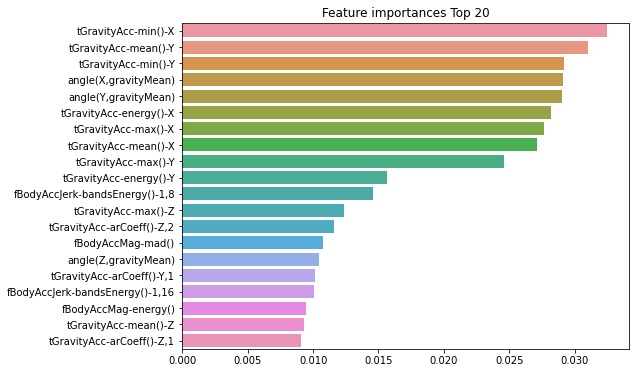

In [ ]:
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()

## **GBM(Gradient Boosting Machine)**

부스팅 알고리즘: 여러 개의 약한 학습기를 순차적으로 학습-예측하면서 잘못 예측한 데이터에 가중치 부여하여 오류 개선

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
import time
import warnings
warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test = get_human_dataset()

#GBM 수행 시간 측정을 위함. 시작 시간 설정
start_time = time.time()

gb_clf = GradientBoostingClassifier(random_state=0)
gb_clf.fit(X_train, y_train)
gb_pred = gb_clf.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)

print('GBM 정확도: {0:.4f}'.format(gb_accuracy))
print('GBM 수행 시간: {0:.1f}초'.format(time.time() - start_time))

GBM 정확도: 0.9386
GBM 수행 시간: 725.7초


일반적으로 GBM이 랜덤 포레스트보다 예측 성능이 조금 뛰어나지만 수행시간 오래 걸리고 하이퍼 파라미터 튜닝 노력 필요

**GBM 하이퍼 파라미터 및 튜닝**

loss: 경사 하강법에서 사용할 비용 함수, 기본값 ‘deviance’

learning_rate: GBM이 학습 진행할 때마다 적용하는 학습률, weak learner가 순차적으로 오류 값 보정해 나가는 데 적용하는 계수, 기본값 0.1

n_estimators: weak learner의 개수, 기본값 100

subsample: weak learner가 학습에 사용하는 데이터의 샘플링 비율, 기본값 1(전체 학습 데이터를 기반으로 학습)

In [ ]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators' : [100,500],
    'learning_rate' : [0.05, 0.1]
}
grid_cv = GridSearchCV(gb_clf, param_grid=params, cv=2, verbose=2)
grid_cv.fit(X_train, y_train)
print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터:
 {'learning_rate': 0.05, 'n_estimators': 500}
최고 예측 정확도: 0.9002


In [ ]:
#GridSearchCV를 이용해 최적으로 학습된 estimator로 예측 수행
gb_pred = grid_cv.best_estimator_.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)
print('GBM 정확도: {0:.4f}'.format(gb_accuracy))

GBM 정확도: 0.9393


과적합에도 강한 뛰어난 예측 성능 가지지만 수행 시간 오래 걸림

## **XGBoost (eXtra Gradient Boost)**

- GBM 기반
- 병렬 수행 가능하여 GBM 대비 빠른 수행 시간
- 자체 내장된 교차 검증, 평가 값이 최적화되면 조기 중단
- 과적합 규제 
- tree pruning(가지치기)로 더 이상 긍정 이득이 없는 분할을 가지지기 해서 분할 수를 줄임
- 결손값 자체 처리

In [ ]:
import xgboost as xgb
from xgboost import XGBClassifier

In [ ]:
print(xgb.__version__)

0.90


#### **파이썬 래퍼 XGBoost - 위스콘신 유방암 예측**

In [ ]:
#위스콘신 유방암 데이터는 종양 크기, 모양 등 다양한 속성에 따라 악성종양, 양성종양인지 분류
import xgboost as xgb
from xgboost import plot_importance     #피처의 중요도 시각화
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset = load_breast_cancer()
X_features = dataset.data
y_label = dataset.target

cancer_df = pd.DataFrame(data=X_features, columns=dataset.feature_names)
cancer_df['target'] = y_label
cancer_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [ ]:
#악성인 'malignant'는 0, 양성인 'benign'는 1
print(dataset.target_names)
print(cancer_df['target'].value_counts())

['malignant' 'benign']
1    357
0    212
Name: target, dtype: int64


In [ ]:
#전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size=0.2, random_state=156)
print(X_train.shape, X_test.shape)

(455, 30) (114, 30)


In [ ]:
#파이썬 래퍼 XGBoost는 학습/테스트용 데이터 세트를 위해 DMatrix 생성
#주로 넘파이 입력 파라미터 받음, 주요 입력 파라미터는 피처 데이터 세트인 data, 레이블(분류)/숫자형인 종속값(회귀) 데이터 세트인 label
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

In [ ]:
#하이퍼 파라미터는 주로 딕셔너리 형태
params = {'max_depth':3,
          'eta':0.1,
          'objective':'binary:logistic',    #이진분류
          'eval_metric':'logloss',          #오류 함수의 평가 성능 지표  
          'early_stoppings':100         
        }
num_rounds = 400        #부스팅 반복 횟수

In [ ]:
#조기 중단할 수 있는 최소 반복 횟수 파라미터인 early_stopping_rounds 설정하면 반드시 eval_set, eval_metric 함께 설정
#train 데이터 세트는 'train', evaluation(test) 데이터 세트는 'eval'로 명기
wlist = [(dtrain, 'train'), (dtest, 'eval')]
#하이퍼 파라미터와 early stopping 파라미터를 train()함수의 파라미터로 전달
xgb_model = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_rounds, early_stopping_rounds=100, evals=wlist)

[0]	train-logloss:0.609688	eval-logloss:0.61352
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 100 rounds.
[1]	train-logloss:0.540803	eval-logloss:0.547842
[2]	train-logloss:0.483753	eval-logloss:0.494248
[3]	train-logloss:0.434457	eval-logloss:0.447986
[4]	train-logloss:0.39055	eval-logloss:0.409109
[5]	train-logloss:0.354145	eval-logloss:0.374977
[6]	train-logloss:0.321222	eval-logloss:0.345714
[7]	train-logloss:0.292592	eval-logloss:0.320529
[8]	train-logloss:0.267467	eval-logloss:0.29721
[9]	train-logloss:0.245153	eval-logloss:0.277991
[10]	train-logloss:0.225694	eval-logloss:0.260302
[11]	train-logloss:0.207937	eval-logloss:0.246037
[12]	train-logloss:0.192184	eval-logloss:0.231556
[13]	train-logloss:0.177916	eval-logloss:0.22005
[14]	train-logloss:0.165222	eval-logloss:0.208572
[15]	train-logloss:0.153622	eval-logloss:0.199993
[16]	train-logloss:0.14333	eval-logloss:0.190118
[17]	train-logl

In [ ]:
#xgboost의 predict()는 예측 결과값이 아닌 예측 결과를 추정할 수 있는 확률 값 반환 -> 0.5보다 크면 1, 0.5보다 작으면 0
pred_probs = xgb_model.predict(dtest)
print('predict() 수행 결과값을 20개만 표시, 예측 확률값으로 표시됨')
print(np.round(pred_probs[:20], 3))

#예측 확률이 0.5보다 크면 1, 그렇지 않으면 0으로 예측값 결정해 리스트 객체인 preds에 저장
preds = [1 if x > 0.5 else 0 for x in pred_probs]
print('예측값 20개만 표시:', preds[:20])

predict() 수행 결과값을 20개만 표시, 예측 확률값으로 표시됨
[0.934 0.003 0.91  0.094 0.993 1.    1.    0.999 0.997 0.    0.    0.
 1.    1.    0.999 0.991 0.995 1.    1.    1.   ]
예측값 20개만 표시: [1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import f1_score, roc_auc_score
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC: {4:.4f}'
          .format(accuracy, precision, recall, f1, roc_auc))

In [ ]:
get_clf_eval(y_test, preds, pred_probs)

오차 행렬
[[35  2]
 [ 1 76]]
정확도: 0.9737, 정밀도: 0.9744, 재현율: 0.9870, F1: 0.9806, AUC: 0.9951


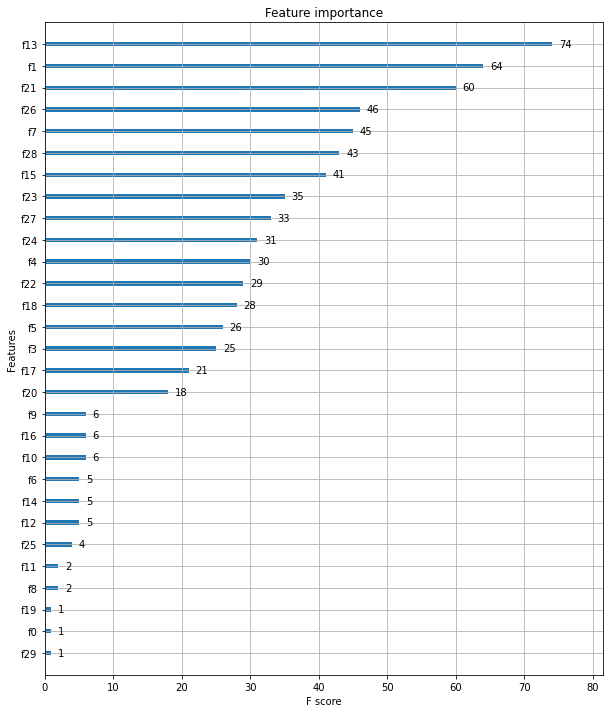

In [ ]:
#f1 스코어를 기반으로 해 각 피처의 중요도 시각화
#plot_importance로 호출 시 파라미터로 학습 완료된 모델 객체와 matplotlib의 ax 객체 입력, 피처 순서별로 f0, f1, ... 
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10,12))
plot_importance(xgb_model, ax=ax)

xgboost의 to_graphviz() 사용하면 결정 트리의 규칙 구조 그릴 수 있음. 파라미터로 학습 완료된 모델 객체와 Graphviz가 참조할 파일명 입력

GridSearchCV와 유사하게 교차 검증 수행 후 최적 파라미터 구하는 cv() 제공

#### **사이킷런 래퍼 XGBoost - 위스콘신 유방암 예측**

In [ ]:
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(m_estimators=400, learning_rate=0.1, max_depth=3)
xgb_wrapper.fit(X_train, y_train)
w_preds = xgb_wrapper.predict(X_test)
w_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

In [ ]:
get_clf_eval(y_test, w_preds, w_pred_proba)

오차 행렬
[[34  3]
 [ 2 75]]
정확도: 0.9561, 정밀도: 0.9615, 재현율: 0.9740, F1: 0.9677, AUC: 0.9947


In [ ]:
#fit()에 조기 중단 관련 파라미터인 early_stoppint_rounds, eval_metric(조기 중단 위한 평가 지표), eval_set(평가 수행할 데이터) 입력하여 조기중단 가능
#성능 평가 수행할 데이터 세트는 학습 데이터가 아니라 별도의 데이터 세트여야함

#아래 코드에서는 평가 데이터 세트로 테스트 데이터 세트 이용, 바람직하지 X
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
evals = [(X_test, y_test)]
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="logloss", eval_set=evals, verbose=True)
ws100_preds = xgb_wrapper.predict(X_test)
ws100_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

[0]	validation_0-logloss:0.61352
Will train until validation_0-logloss hasn't improved in 100 rounds.
[1]	validation_0-logloss:0.547842
[2]	validation_0-logloss:0.494248
[3]	validation_0-logloss:0.447986
[4]	validation_0-logloss:0.409109
[5]	validation_0-logloss:0.374977
[6]	validation_0-logloss:0.345714
[7]	validation_0-logloss:0.320529
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.277991
[10]	validation_0-logloss:0.260302
[11]	validation_0-logloss:0.246037
[12]	validation_0-logloss:0.231556
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.208572
[15]	validation_0-logloss:0.199993
[16]	validation_0-logloss:0.190118
[17]	validation_0-logloss:0.181818
[18]	validation_0-logloss:0.174729
[19]	validation_0-logloss:0.167657
[20]	validation_0-logloss:0.158202
[21]	validation_0-logloss:0.154725
[22]	validation_0-logloss:0.148947
[23]	validation_0-logloss:0.143308
[24]	validation_0-logloss:0.136344
[25]	validation_0-logloss:0.132778
[26]	validation_0-logloss:0.127912

211에서 311까지 early_stopping_rounds으로 설정된 100번 반복동안 성능 평가 지수가 향상되지 않아서 400번까지 반복 수행하지 않고 멈춤

하지만 조기 중단값 너무 급격하게 줄이면 충분한 학습이 되지 않아 예측 성능 저하될 우려가 큼



In [ ]:
get_clf_eval(y_test, ws100_preds, ws100_pred_proba)

오차 행렬
[[34  3]
 [ 1 76]]
정확도: 0.9649, 정밀도: 0.9620, 재현율: 0.9870, F1: 0.9744, AUC: 0.9954


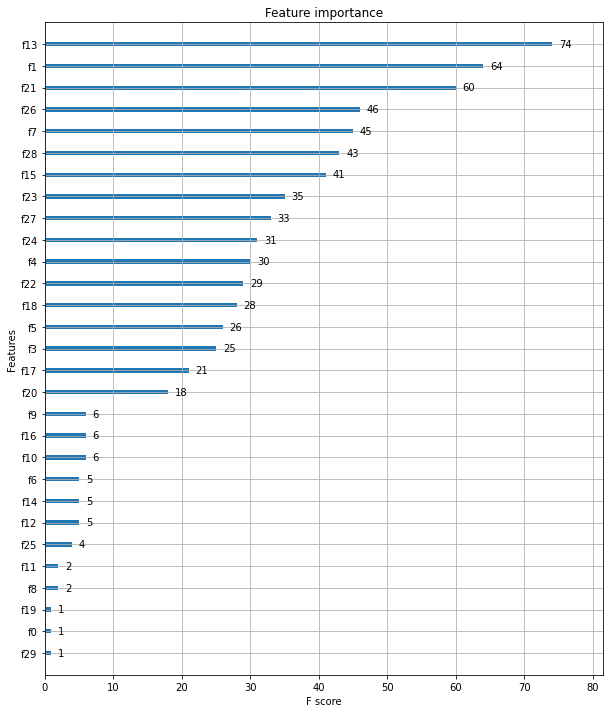

In [ ]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(figsize=(10,12))

#사이킷런 wrapper 클래스 입력해도 무방
plot_importance(xgb_wrapper, ax=ax)

## **LightGBM**

In [ ]:
import lightgbm
lightgbm.__version__

'2.2.3'

#### **LightGBM - 위스콘신 유방암 예측**

In [ ]:
#LightGBM의 파이썬 패키지인 lightgbm에서 LGBMClassifier import
from lightgbm import LGBMClassifier

import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset = load_breast_cancer()
ftr = dataset.data
target = dataset.target

#전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test = train_test_split(ftr, target, test_size=0.2, random_state=156)

#앞서 XGBoost와 동일하게 n_estimators는 400 설정
lgbm_wrapper = LGBMClassifier(n_estimators=400)

#LightGBM도 XGBoost와 동일하게 조기 중단 수행 가능
evals = [(X_test, y_test)]
lgbm_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="logloss", eval_set=evals, verbose=True)
preds = lgbm_wrapper.predict(X_test)
pred_proba = lgbm_wrapper.predict_proba(X_test)[:, 1]

[1]	valid_0's binary_logloss: 0.565079	valid_0's binary_logloss: 0.565079
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.507451	valid_0's binary_logloss: 0.507451
[3]	valid_0's binary_logloss: 0.458489	valid_0's binary_logloss: 0.458489
[4]	valid_0's binary_logloss: 0.417481	valid_0's binary_logloss: 0.417481
[5]	valid_0's binary_logloss: 0.385507	valid_0's binary_logloss: 0.385507
[6]	valid_0's binary_logloss: 0.355846	valid_0's binary_logloss: 0.355846
[7]	valid_0's binary_logloss: 0.330897	valid_0's binary_logloss: 0.330897
[8]	valid_0's binary_logloss: 0.306923	valid_0's binary_logloss: 0.306923
[9]	valid_0's binary_logloss: 0.28776	valid_0's binary_logloss: 0.28776
[10]	valid_0's binary_logloss: 0.26917	valid_0's binary_logloss: 0.26917
[11]	valid_0's binary_logloss: 0.250954	valid_0's binary_logloss: 0.250954
[12]	valid_0's binary_logloss: 0.23847	valid_0's binary_logloss: 0.23847
[13]	valid_0's binary_logloss: 0.225865	valid_0's bi

In [ ]:
preds[:20]

array([1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
pred_proba[:20]

array([0.79963441, 0.01074376, 0.95270335, 0.28471512, 0.95969714,
       0.99654716, 0.99616392, 0.99233044, 0.99469375, 0.00501306,
       0.00842098, 0.00589279, 0.9967109 , 0.99636762, 0.991706  ,
       0.98112602, 0.97641439, 0.99496749, 0.99475115, 0.99594264])

In [ ]:
get_clf_eval(y_test, preds, pred_proba)

오차 행렬
[[33  4]
 [ 2 75]]
정확도: 0.9474, 정밀도: 0.9494, 재현율: 0.9740, F1: 0.9615, AUC: 0.9926


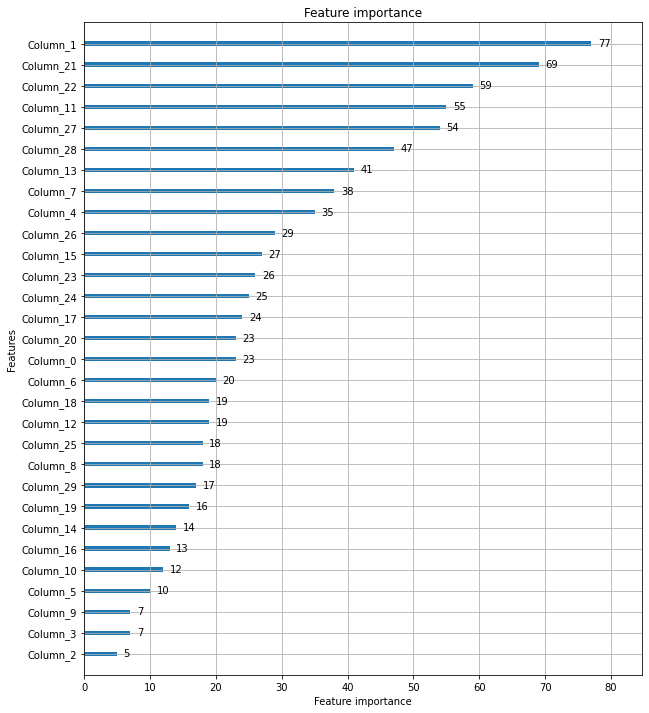

In [ ]:
#lightgbm은 xgboost와 동일하게 피처 중요도 시각화하는 plot_importance() 제공, 사이킷런 래퍼 클래스 입력해도 ok
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10,12))
plot_importance(lgbm_wrapper, ax=ax)

lightgbm의 plot_importance()도 numpy로 피처 데이터를 학습하면 피처명을 알 수 없어서 Column_ 뒤에 피처 순서대로 숫자 붙여서 나열

## **스태킹 앙상블**

### **기본 Stacking 모델** 

In [ ]:
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer_data = load_breast_cancer()

X_data = cancer_data.data
y_label = cancer_data.target

X_train, X_test, y_train, y_test = train_test_split(X_data, y_label, test_size=0.2, random_state=0)

In [ ]:
#스태킹에 사용될 개별 ML 모델 생성
knn_clf = KNeighborsClassifier(n_neighbors=4)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=0)
dt_clf = DecisionTreeClassifier()
ada_clf = AdaBoostClassifier(n_estimators=100)

#스태킹으로 만들어진 데이터 세트를 학습, 예측할 최종 모델
lr_final = LogisticRegression(C=10)

#개별 모델들 학습
knn_clf.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)
dt_clf.fit(X_train, y_train)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=100)

In [ ]:
#학습된 개별 모델들이 각자 반환하는 예측 데이터 세트를 생성하고 개별 모델의 정확도 측정
knn_pred = knn_clf.predict(X_test)
rf_pred = rf_clf.predict(X_test)
dt_pred = dt_clf.predict(X_test)
ada_pred = ada_clf.predict(X_test)

print('KNN 정확도: {0:.4f}'.format(accuracy_score(y_test, knn_pred)))
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy_score(y_test, rf_pred)))
print('결정 트리 정확도: {0:.4f}'.format(accuracy_score(y_test, dt_pred)))
print('에이다부스트 정확도: {0:.4f}'.format(accuracy_score(y_test, ada_pred)))

KNN 정확도: 0.9211
랜덤 포레스트 정확도: 0.9649
결정 트리 정확도: 0.9035
에이다부스트 정확도: 0.9561


In [ ]:
#반환된 예측 결과를 행 형태로 붙인 뒤, tranpose()를 사용해 행과 열 위치 바꾼 후 ndarray로 변환
pred = np.array([knn_pred, rf_pred, dt_pred, ada_pred])
print(pred.shape)

#transpose()를 이용해 행과 열의 위치 교환, 칼럼 레벨로 각 알고리즘의 예측 결과를 피처로 만듦
pred = np.transpose(pred)
print(pred.shape)

(4, 114)
(114, 4)


In [ ]:
#예측 데이터로 생성된 데이터 세트를 기반으로 최종 메타 모델인 로지스틱 회귀를 학습하고 예측 정확도 측정
#이 코드는 테스트용 레이블 데이터 세트를 기반으로 학습하여서 과적합 문제 발생할 수 있음
lr_final.fit(pred, y_test)
final = lr_final.predict(pred)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test, final)))

최종 메타 모델의 예측 정확도: 0.9737


### **CV 세트 기반의 Stacking**

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

#개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds):
    #지정된 n_folds 값으로 KFold 생성
    kf = KFold(n_splits=n_folds, shuffle=False)
    #추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화
    train_fold_pred = np.zeros((X_train_n.shape[0], 1))
    test_pred = np.zeros((X_test_n.shape[0], n_folds))
    print(model.__class__.__name__, 'model 시작')

    for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        #입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 세트 추출
        print('\t폴드 세트:', folder_counter, ' 시작')
        X_tr = X_train_n[train_index]
        y_tr = y_train_n[train_index]
        X_te = X_train_n[valid_index]

        #폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행
        model.fit(X_tr, y_tr)
        #폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1, 1)
        #입력된 원본 테스트 데이터를 폴드 세트 내 학습된 기반 모델에서 예측 후 데이터 저장
        test_pred[:, folder_counter] = model.predict(X_test_n)

    #폴드 세트 내에서 원본 데이터를 예측한 데이터를 평균하여 테스트 데이터 생성
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1, 1)

    #train_fold_pred는 최종 메타 모델의 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred, test_pred_mean

In [ ]:
knn_train, knn_test = get_stacking_base_datasets(knn_clf, X_train, y_train, X_test, 7)
rf_train, rf_test = get_stacking_base_datasets(rf_clf, X_train, y_train, X_test, 7)
dt_train, dt_test = get_stacking_base_datasets(dt_clf, X_train, y_train, X_test, 7)
ada_train, ada_test = get_stacking_base_datasets(ada_clf, X_train, y_train, X_test, 7)

KNeighborsClassifier model 시작
	폴드 세트: 0  시작
	폴드 세트: 1  시작
	폴드 세트: 2  시작
	폴드 세트: 3  시작
	폴드 세트: 4  시작
	폴드 세트: 5  시작
	폴드 세트: 6  시작
RandomForestClassifier model 시작
	폴드 세트: 0  시작
	폴드 세트: 1  시작
	폴드 세트: 2  시작
	폴드 세트: 3  시작
	폴드 세트: 4  시작
	폴드 세트: 5  시작
	폴드 세트: 6  시작
DecisionTreeClassifier model 시작
	폴드 세트: 0  시작
	폴드 세트: 1  시작
	폴드 세트: 2  시작
	폴드 세트: 3  시작
	폴드 세트: 4  시작
	폴드 세트: 5  시작
	폴드 세트: 6  시작
AdaBoostClassifier model 시작
	폴드 세트: 0  시작
	폴드 세트: 1  시작
	폴드 세트: 2  시작
	폴드 세트: 3  시작
	폴드 세트: 4  시작
	폴드 세트: 5  시작
	폴드 세트: 6  시작


In [ ]:
Stack_final_X_train = np.concatenate((knn_train, rf_train, dt_train, ada_train), axis=1)
Stack_final_X_test = np.concatenate((knn_test, rf_test, dt_test, ada_test), axis=1)
print('원본 학습 피처 데이터 shape:', X_train.shape, '원본 테스트 피처 shape:', X_test.shape)
print('스태킹 학습 피처 데이터 shape:', Stack_final_X_train.shape, '스태킹 테스트 피처 데이터 shape:', Stack_final_X_test.shape)

원본 학습 피처 데이터 shape: (455, 30) 원본 테스트 피처 shape: (114, 30)
스태킹 학습 피처 데이터 shape: (455, 4) 스태킹 테스트 피처 데이터 shape: (114, 4)


Stack_final_X_train은 메타 모델이 학습할 학습용 피처 데이터 세트, 원본 학습 피처 데이터와 row는 같으며 4개의 개별 모델 예측값을 합친 것이므로 column은 4

Stack_final_X_test는 메타 모델이 예측할 테스트용 피처 데이터 세트

In [ ]:
#스태킹된 학습용 피처 데이터와 원본 학습 레이블 데이터로 학습한 후에 
#스태킹된 테스트 데이터로 예측하고 예측 결과를 원본 테스트 레이블 데이터와 비교하여 정확도 측정

lr_final.fit(Stack_final_X_train, y_train)
stack_final = lr_final.predict(Stack_final_X_test)
print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test,stack_final)))

#스태킹 모델의 파라미터 튜닝은 개별 알고리즘 모델의 파라미터를 최적으로 튜닝하는 것
#스태킹 모델은 분류 / 회귀에도 적용 가능

최종 메타 모델의 예측 정확도: 0.9737
